### Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 7938</pre>

In [30]:
# student 1: Israel 7938
# student 2: Eran 6215
# student 3: Avihai 2474
# student 4: Almog 8269
# student 5: Liron 5068
# student 6: Matan ####

## Part 2 - Experiments
You could add as many code cells as needed

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns

In [32]:
df_train = pd.read_csv('titanic_train.csv')
survivedMan = df_train[(df_train['Sex'] == 1) & (df_train['Age'] > 18) & (df_train['Survived'] == 1)]
survivedManCount = len(survivedMan)
print("Survived man :",survivedManCount)

#Women
survivedWomen = df_train[(df_train['Sex'] == 0) & (df_train['Age'] > 18) & (df_train['Survived'] == 1)]
survivedWomenCount = len(survivedWomen)
print("survived women:",survivedWomenCount)

survivedKids = df_train[(df_train['Age'] <= 18) & (df_train['Survived'] == 1)]
survivedKidsCount = len(survivedKids)
print("survived kids",survivedKidsCount)

survivedCount = len(df_train[df_train['Survived'] == 1])

Survived man : 69
survived women: 156
survived kids 56


In [33]:
df_train.isnull().sum() 

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64

## Visualization

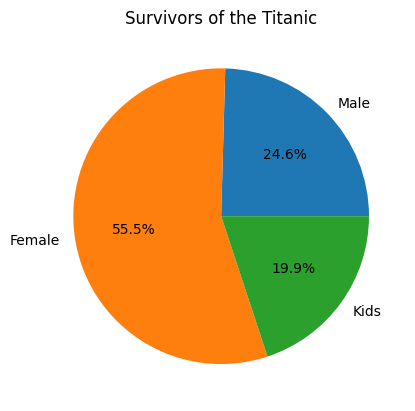

In [34]:
population = [survivedManCount,survivedWomenCount,survivedKidsCount]
labels = ['Male', 'Female','Kids']
fig,ax = plt.subplots()
ax.pie(population,labels = labels,autopct='%1.1f%%')
plt.title('Survivors of the Titanic')
plt.show()

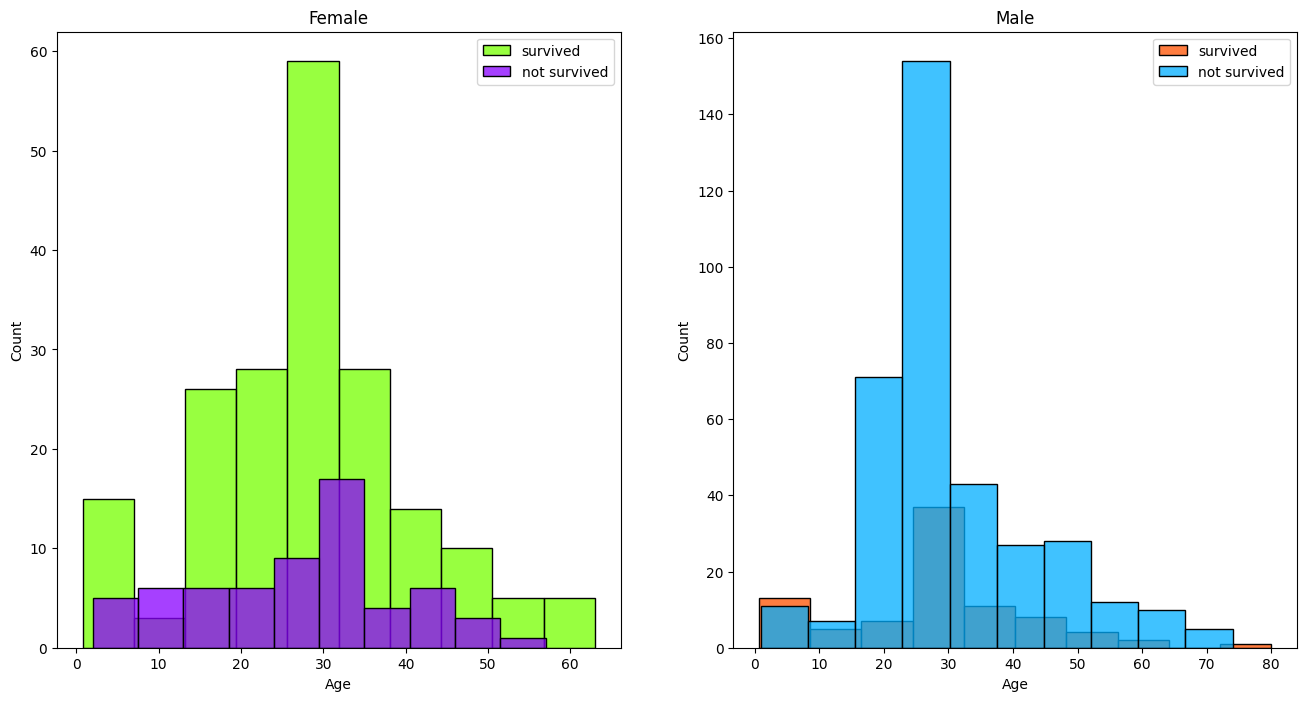

In [73]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
women = df_train[df_train['Sex']==0]
men = df_train[df_train['Sex']==1]
ax = sns.histplot(women[women['Survived']==1].Age.dropna(), bins=10, label = survived, ax = axes[0], kde =False, color="#76FF00")
ax = sns.histplot(women[women['Survived']==0].Age.dropna(), bins=10, label = not_survived, ax = axes[0], kde =False, color="#8900FF")
ax.legend()
ax.set_title('Female')#FFFFFF
ax = sns.histplot(men[men['Survived']==1].Age.dropna(), bins=10, label = survived, ax = axes[1], kde = False, color="#FF5100")
ax = sns.histplot(men[men['Survived']==0].Age.dropna(), bins=10, label = not_survived, ax = axes[1], kde = False, color="#00AEFF")
ax.legend()
_ = ax.set_title('Male');

## Part 3 - Training flow
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 2)

In [36]:
train_set = pd.read_csv("titanic_train.csv")
train_set.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


## Part 4 - Apply on test and show model performance estimation

In [37]:
test_set = pd.read_csv("titanic_test.csv")